In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from sklearn.linear_model import LogisticRegression

## IMDB dataset and the sentiment classification task

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

To get the dataset, in your terminal run the following commands:

`wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz`

`gunzip aclImdb_v1.tar.gz`

`tar -xvf aclImdb_v1.tar`

### Tokenizing and term document matrix creation (bag of words representation [no order])

In [13]:
PATH='data/aclImdb/'
names = ['neg','pos']

In [12]:
%ls {PATH}

ls: data/aclImdb/: No such file or directory


In [22]:
%ls {PATH}train

aclImdb/  all_val/         neg/  tmp/    unsupBow.feat  urls_pos.txt
all/      labeledBow.feat  pos/  unsup/  urls_neg.txt   urls_unsup.txt


In [23]:
%ls {PATH}train/pos | head

0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
ls: write error


In [9]:
trn,trn_y = texts_labels_from_folders(f'{PATH}train',names)
val,val_y = texts_labels_from_folders(f'{PATH}test',names)

Here is the text of the first review

In [25]:
trn[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [26]:
trn_y[0]

0

[`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts (part of `sklearn.feature_extraction.text`).

In [10]:
veczr = CountVectorizer(tokenizer=tokenize)

`fit_transform(trn)` finds the vocabulary in the training set. It also transforms the training set into a term-document matrix. Since we have to apply the *same transformation* to your validation set, the second line uses just the method `transform(val)`. `trn_term_doc` and `val_term_doc` are sparse matrices. `trn_term_doc[i]` represents training document i and it contains a count of words for each document for each word in the vocabulary.

In [11]:
trn_term_doc = veczr.fit_transform(trn) # creates vocab, term document matrix based on training set
val_term_doc = veczr.transform(val)     # use previously created vocab (training set) to create bag of words for validation set

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [29]:
trn_term_doc

<25000x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 3749745 stored elements in Compressed Sparse Row format>

In [30]:
trn_term_doc[0]

<1x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 93 stored elements in Compressed Sparse Row format>

In [31]:
# integer to word
vocab = veczr.get_feature_names(); vocab[5000:5005]

['aussie', 'aussies', 'austen', 'austeniana', 'austens']

In [32]:
w0 = set([o.lower() for o in trn[0].split(' ')]); w0

{'a',
 'absurd',
 'an',
 'and',
 'audience',
 'be',
 'better',
 'briefly.',
 'by',
 'can',
 'chantings',
 'cinematography',
 'comedy.',
 'crazy',
 'cryptic',
 'dialogue',
 'easy',
 'era',
 'even',
 'eventually',
 'example',
 'feelings',
 'for',
 'formal',
 'forrest',
 'frederic',
 'from',
 'future',
 'general',
 'good',
 'grader.',
 'great',
 'has',
 'insane,',
 'into',
 'is',
 'it',
 "it's",
 'just',
 'kirkland',
 'level',
 'make',
 'making',
 'man',
 'might',
 'mob',
 'narrative',
 'no',
 'of',
 'off',
 'off.',
 'on',
 'opening',
 'orchestra',
 'out',
 'pig.',
 'putting.',
 'sally',
 'scene',
 'seem',
 'seen',
 'shakespeare',
 'should',
 'singers.',
 'some',
 'stars',
 'starts',
 'stays',
 'story',
 'technical',
 'terrific',
 'than',
 'that',
 'the',
 'think',
 'third',
 'those',
 'time',
 'to',
 'too',
 'turned',
 'unfortunately',
 'unnatural',
 'vilmos',
 'violent',
 'who',
 'whole',
 'with',
 'would',
 'you',
 'zsigmond.'}

In [33]:
len(w0)

91

In [34]:
# reverse map -> word to integer
veczr.vocabulary_['absurd']

1297

In [35]:
trn_term_doc[0,1297]

2

In [36]:
trn_term_doc[0,5000]

0

## Naive Bayes

'Naive' because it assumes word independence.  Not actually the case in language (context matters)...

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ (vocab) in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [89]:
def pr(y_i):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [90]:
x=trn_term_doc
y=trn_y

r = np.log(pr(1)/pr(0))
b = np.log((y==1).mean() / (y==0).mean())

Here is the formula for Naive Bayes.

In [84]:
# This is simply a weight matrix product plus a bias
# We know other ways to improve weights and biases -> learn them in a logistic regression!
pre_preds = val_term_doc @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.80691999999999997

...and binarized Naive Bayes.

In [91]:
# as it turns out, it doesn't really matter if a certain word appeared more than once.  
# The most important thing is that it appeared.
# .sign() replaces anything positive with 1 and anything negative with -1
x=trn_term_doc.sign()
r = np.log(pr(1)/pr(0))

pre_preds = val_term_doc.sign() @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.83016000000000001

### Logistic regression

Here is how we can fit logistic regression where the features are the unigrams.

In [22]:
# dual=True : use when matrix is much wider than it is tall, this helps to speed things up (mathematical magic...)
# C : regularization (via weight decay -- derivative of weights and penalty)
m = LogisticRegression(C=1e8, dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

# Learning the weights/biases turns out better than calculating them based on theory...

0.85504000000000002

binary version

In [23]:
m = LogisticRegression(C=1e8, dual=True)
m.fit(trn_term_doc.sign(), y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.85487999999999997

...and the regularized version (inverse -> decrease C [low number means greater regularization])

In [24]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.88275999999999999

regularized binary version

In [25]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc.sign(), y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.88404000000000005

** ML PRO-TIP: **  
- use lots of parameters to improve model accuracy
- use regularization to limit overfitting and generalize well

### Trigram with NB features

We can specify ngrams (collections of words) in our tokenizer -> makes bag of words models much more useful

Our next model is a version of logistic regression with Naive Bayes features described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment.

In [7]:
# max_features=n -> sorts ngrams by occurence and takes n of the most used ngrams 
veczr =  CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, max_features=800000)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

NameError: name 'trn' is not defined

In [10]:
trn_term_doc.shape

(25000, 800000)

In [11]:
vocab = veczr.get_feature_names()

In [12]:
vocab[200000:200005]

['by vast', 'by vengeance', 'by vengeance .', 'by vera', 'by vera miles']

In [13]:
y=trn_y
x=trn_term_doc.sign()
val_x = val_term_doc.sign()

In [16]:
r = np.log(pr(1) / pr(0))
b = np.log((y==1).mean() / (y==0).mean())

Here we fit regularized logistic regression where the features are the trigrams.

In [42]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y);

preds = m.predict(val_x)
(preds.T==val_y).mean()

0.90500000000000003

Here is the $\text{log-count ratio}$ `r`.  

In [43]:
r.shape, r

((1, 800000),
 matrix([[-0.05468, -0.161  , -0.24784, ...,  1.09861, -0.69315, -0.69315]]))

In [44]:
np.exp(r)

matrix([[ 0.94678,  0.85129,  0.78049, ...,  3.     ,  0.5    ,  0.5    ]])

Here we fit regularized logistic regression where the features are the trigrams' log-count ratios.

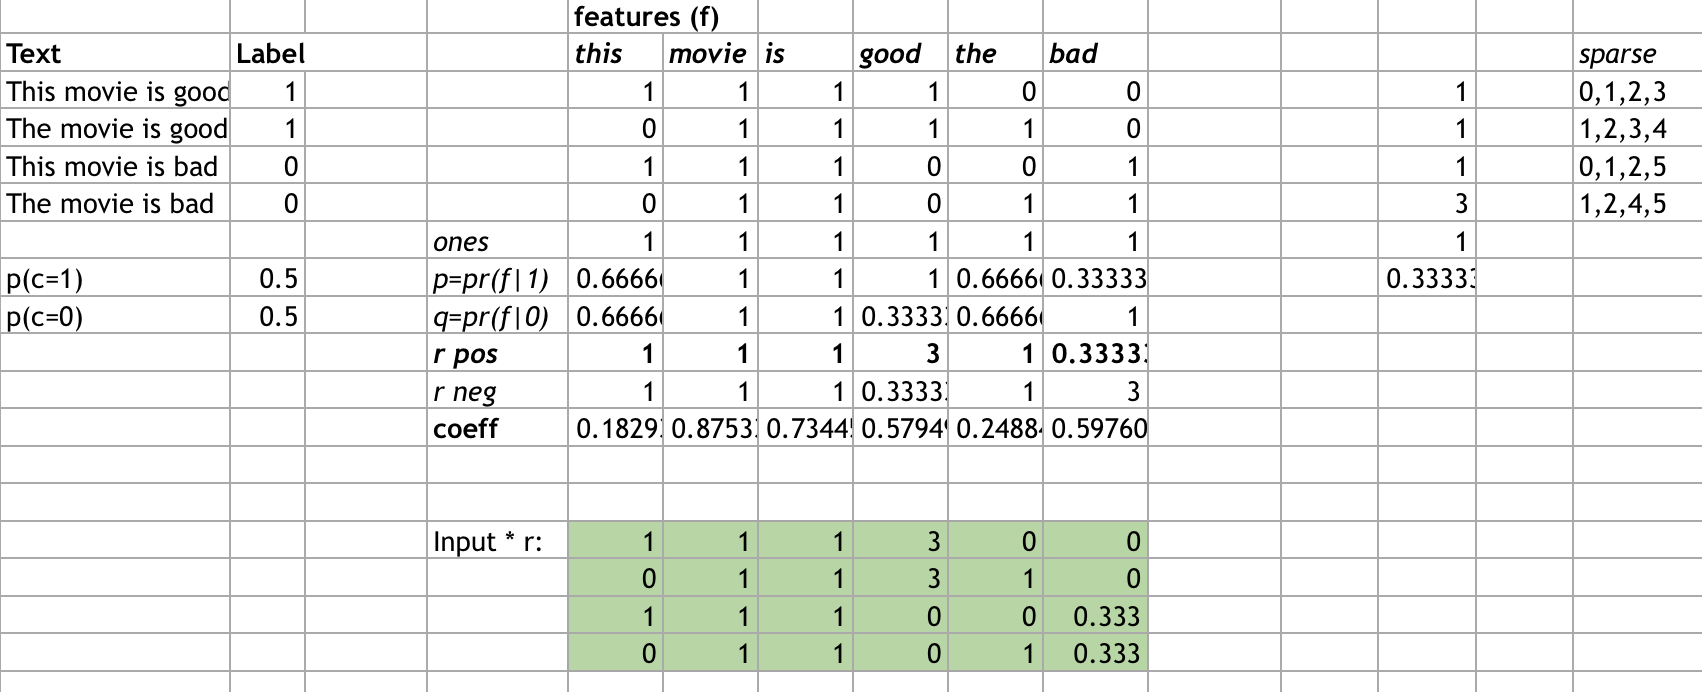

In [45]:
# multiply term document matrix by r - broadcasted element-wise multiplication
# results in a matrix the shape of the term document where 1s are replaced by r values and 0s are still 0s
x_nb = x.multiply(r)
# use this matrix as independent variables
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y);

val_x_nb = val_x.multiply(r) 
preds = m.predict(val_x_nb)
(preds.T==val_y).mean()

# Why is this performing better?  It should be mathematically equivalent to the above
# Regularization is having a different effect
# Here, regularization is zeroed on the Naive Bayes priors (penalize variance away from r values) here
# Above, regularization was zeroed on 0 (penalties for any variance)

# Use theory (NB priors) for starting point...  Almost like pre-trained weights
# We need less regularization this way

0.91768000000000005

## fastai NBSVM++
fastai version of Naive Bayes-centered regularization

In [17]:
# up to sl unique words per review
sl=2000

In [18]:
# Here is how we get a model from a bag of words
md = TextClassifierData.from_bow(trn_term_doc, trn_y, val_term_doc, val_y, sl)

In [19]:
learner = md.dotprod_nb_learner()   # based on dotproduct of naive bayes
learner.fit(0.02, 1, wds=1e-6, cycle_len=1)

A Jupyter Widget

[ 0.       0.0251   0.12003  0.91552]                          



In [159]:
learner.fit(0.02, 2, wds=1e-6, cycle_len=1)

A Jupyter Widget

[ 0.       0.02014  0.11387  0.92012]                         
[ 1.       0.01275  0.11149  0.92124]                         



In [160]:
learner.fit(0.02, 2, wds=1e-6, cycle_len=1)

A Jupyter Widget

[ 0.       0.01681  0.11089  0.92129]                           
[ 1.       0.00949  0.10951  0.92223]                          



**Embedding: ** Identical to multiplying by a one-hot encoded matrix via a simple array look-up (+ memory efficient)  
Essentially the same thing as a linear layer in this scenario
- expects a list of integers [indices] instead of a one-hot encoded matrix

## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)